# Colorpipeline

#### Code for the vizualization of the color focused pipeline

Besides the transformation to illumination invariant representation rg, a confidence measure is proposed to distinguish between colored and non- colored pixels. In the calculation the uncertainty of the sensor values is taken into account as the transform to the rg space is not linear and small perturbations in the sensor values could lead to large jumps in the transformed image. First the noise $\sigma_R, \sigma_G, \sigma_B$
is estimated for every image, with an extended method of Immerkaers fast noise estimation method. Then the noise is propagated through the transform, leading to expected noise defined by a covariance matrix for every pixel.  Then the Mahalanobis distance is calculated, that provides a distance measure for every pixel, of belonging to the non-colored areas. Based on the distance the probability is calculated that the pixel is colored.

In [1]:
#Dependencies
import os
import math

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt   
import matplotlib.colors as colors
import scipy
from scipy import ndimage, signal, integrate, optimize, stats
from skimage import feature

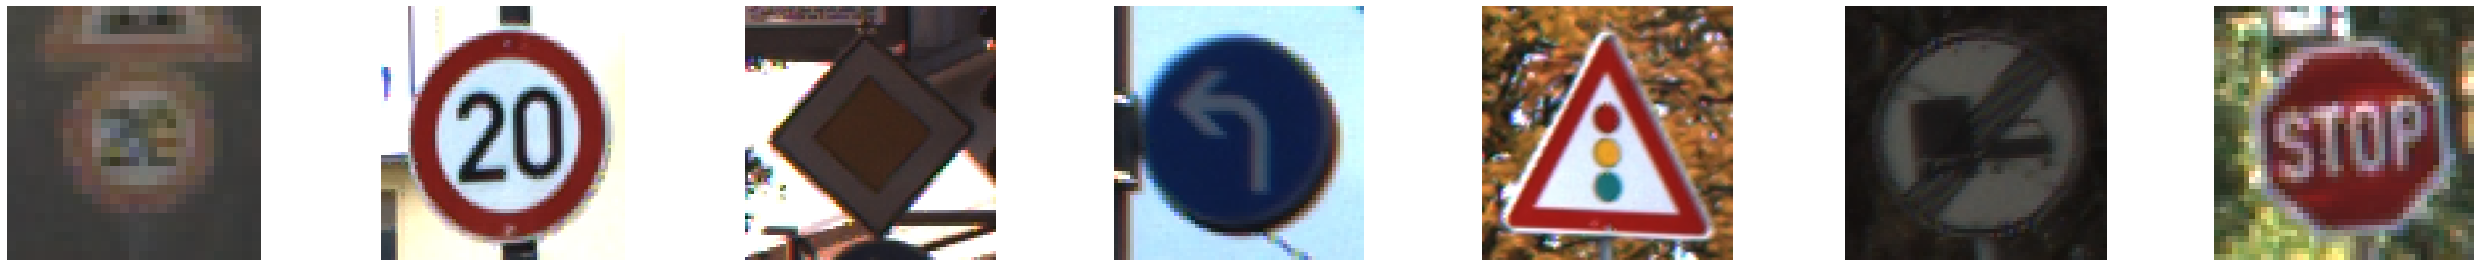

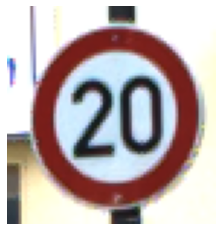

In [2]:
#Load and plot images
from utils_image_load_plot import load_GTSRB_test_images, plot_images, plot_hists, plot_distributions
#TODO!: update path to GTSRB dataset:
images = load_GTSRB_test_images(path = "")
plot_images(images)
plt.axis('off')
plt.imshow(images[1])

## Transform to Normalized rg
$r= \frac{R}{R+G+B}$ $g= \frac{G}{R+G+B}$


normalized_r:


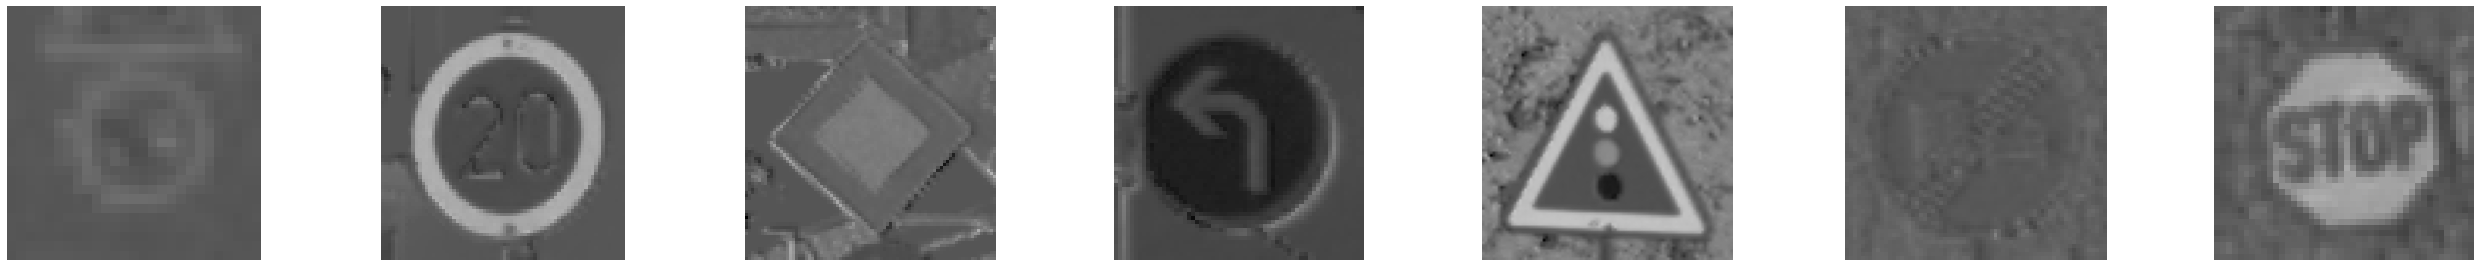

normalized_g:


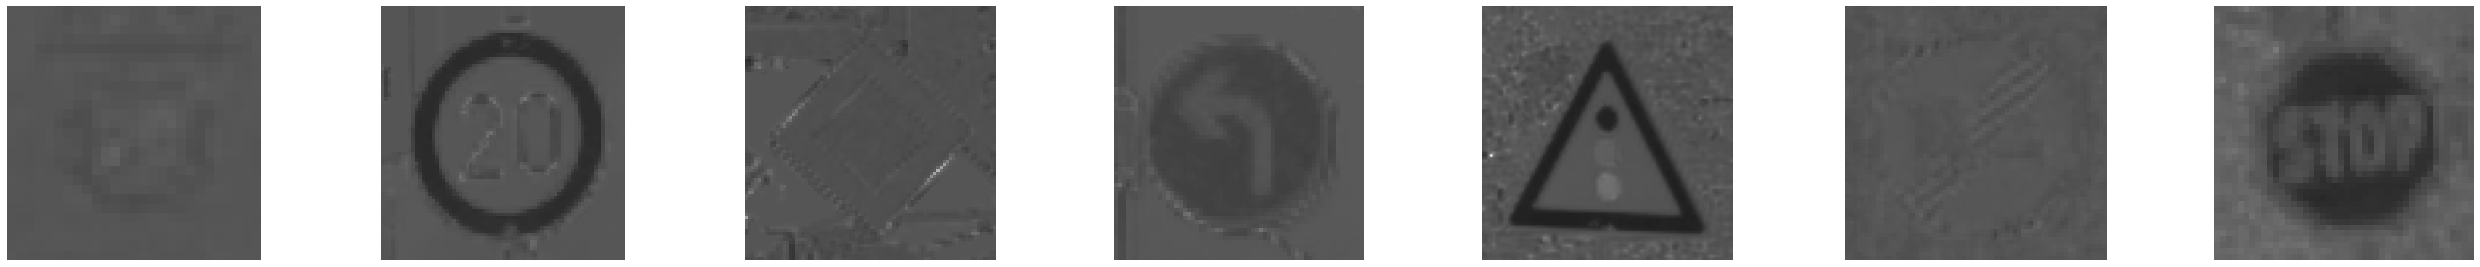

In [3]:
'''
transforms input to normalized rg
    x: np nd-array wit HeightxWidthxColor(RGB space 3 channel)
''' 
def normalizedRG(x):
    intensity = x.sum(axis =2, keepdims = True)
    rgb = np.divide(x, intensity, out= np.full(x.shape,1/3), where=intensity!=0)
    return rgb[:,:,:2]



print("normalized_r:")
plot_images([normalizedRG(img)[:,:,0] for img in images])
print("normalized_g:")
plot_images([normalizedRG(img)[:,:,1] for img in images])


### Color Correction
First apply color correction (Assumption: color space is slightly shifted, a mode should be at 1/3 (all street signs contain white areas)

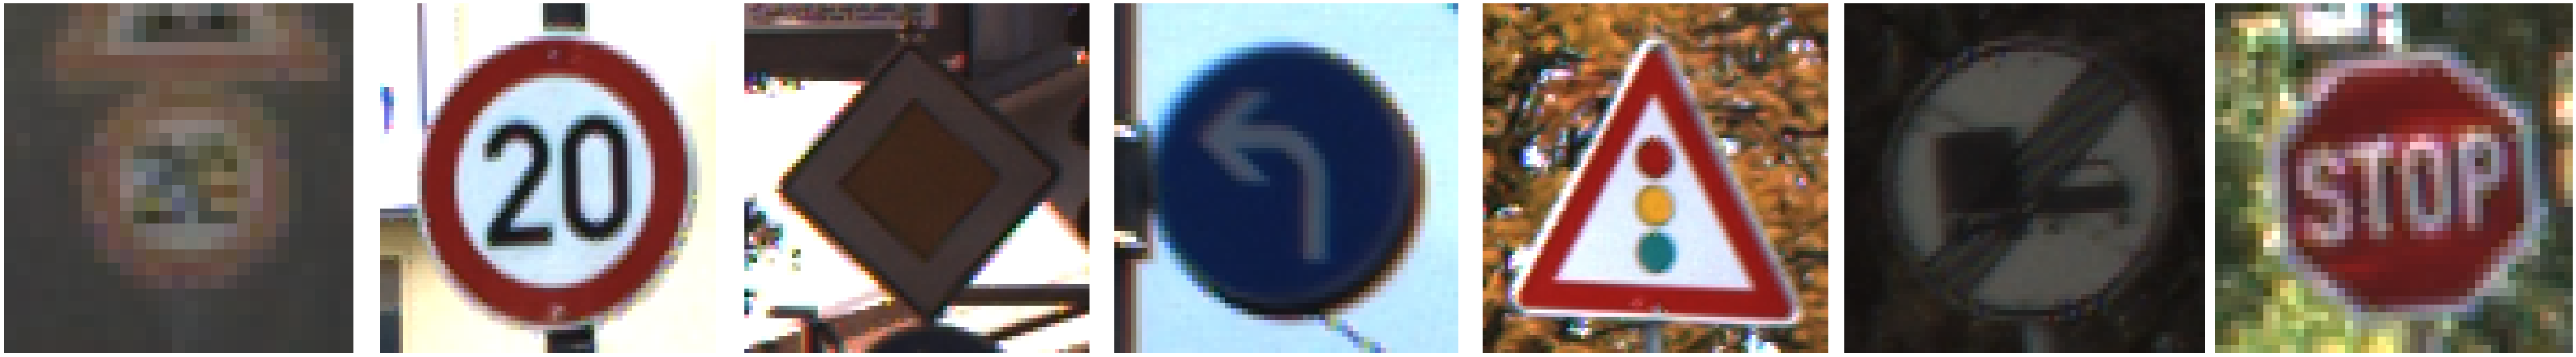

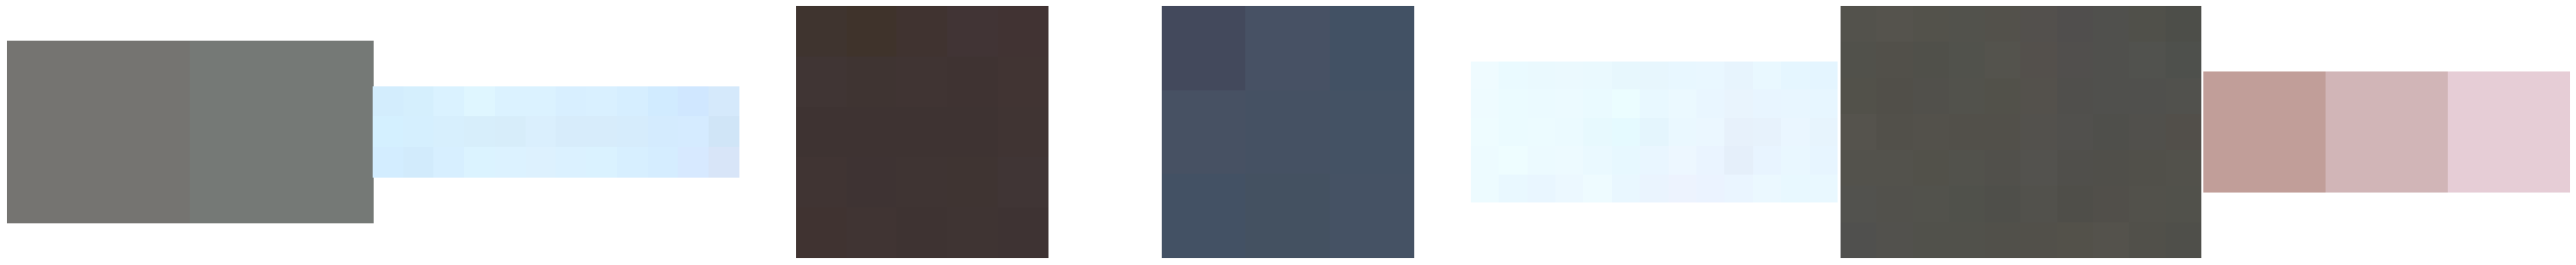

In [4]:
# GT PIXEL AREA to check how they have been color corrected
plot_images(images, size=(10,10))
gt = [((13,17),(15,18)), ((33,55),(45,58)),((40,60),(45,65)),((18,22),(21,25)),((25,70),(38,75)),((35,45),(45,52)), ((17,18),(20,19))]

plot_images([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i,img in enumerate(images)])


input image


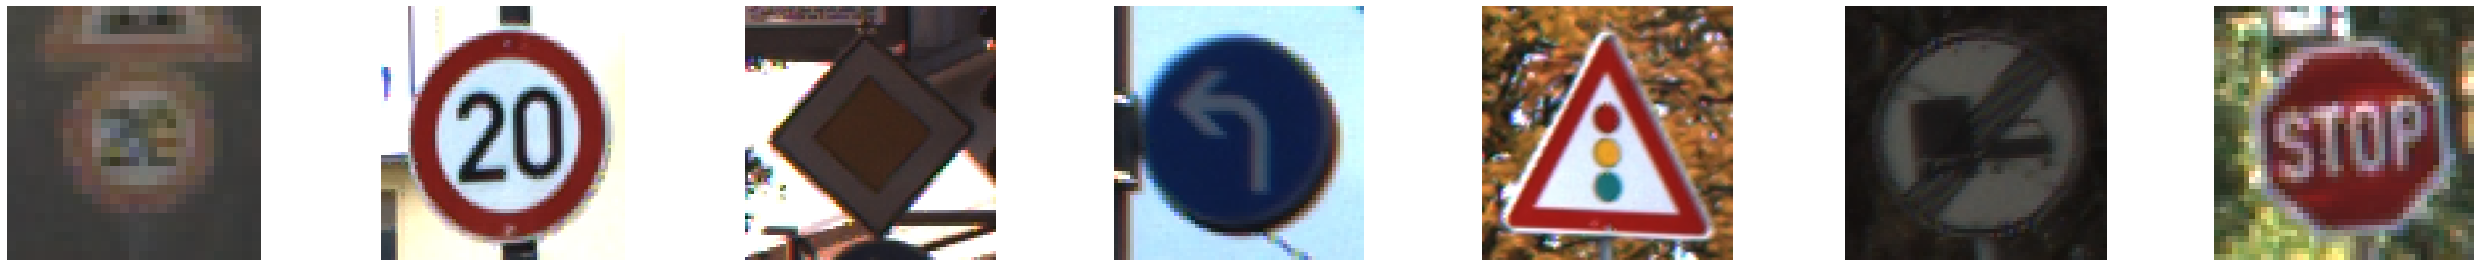

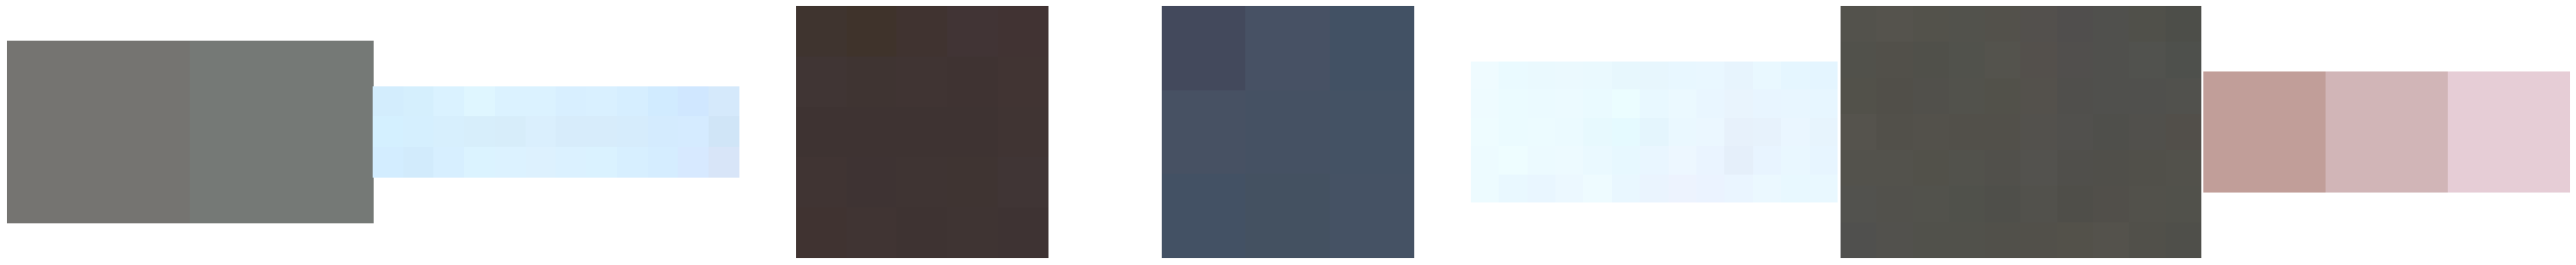

-difference to R=G=B
 -image 0: 3.0
 -image 1: 38.611111111111114
 -image 2: 13.079999999999998
 -image 3: 30.111111111111114
 -image 4: 20.923076923076934
 -image 5: 6.01428571428572
 -image 6: 29.333333333333314

illumination correction(mode):
 r_mode: 0.337, r_factor: 0.990, g_mode: 0.333, g_factor: 1.000
max r+g: 0.7837566594574683
137.5644932758706
 r_mode: 0.333, r_factor: 1.001, g_mode: 0.333, g_factor: 1.001
max r+g: 0.907700953835457
255.21085616927417
 r_mode: 0.333, r_factor: 1.000, g_mode: 0.333, g_factor: 1.001
max r+g: 1.0
255.18934225668525
 r_mode: 0.285, r_factor: 1.170, g_mode: 0.351, g_factor: 0.949
max r+g: 0.9057428224869566
298.36082424528934
 r_mode: 0.333, r_factor: 1.001, g_mode: 0.333, g_factor: 1.001
max r+g: 1.0
255.2503594930539
 r_mode: 0.333, r_factor: 1.001, g_mode: 0.333, g_factor: 1.000
max r+g: 0.8036089090091736
89.11719763861676
 r_mode: 0.333, r_factor: 1.001, g_mode: 0.333, g_factor: 1.001
max r+g: 0.8834642867725576
255.17578869074617


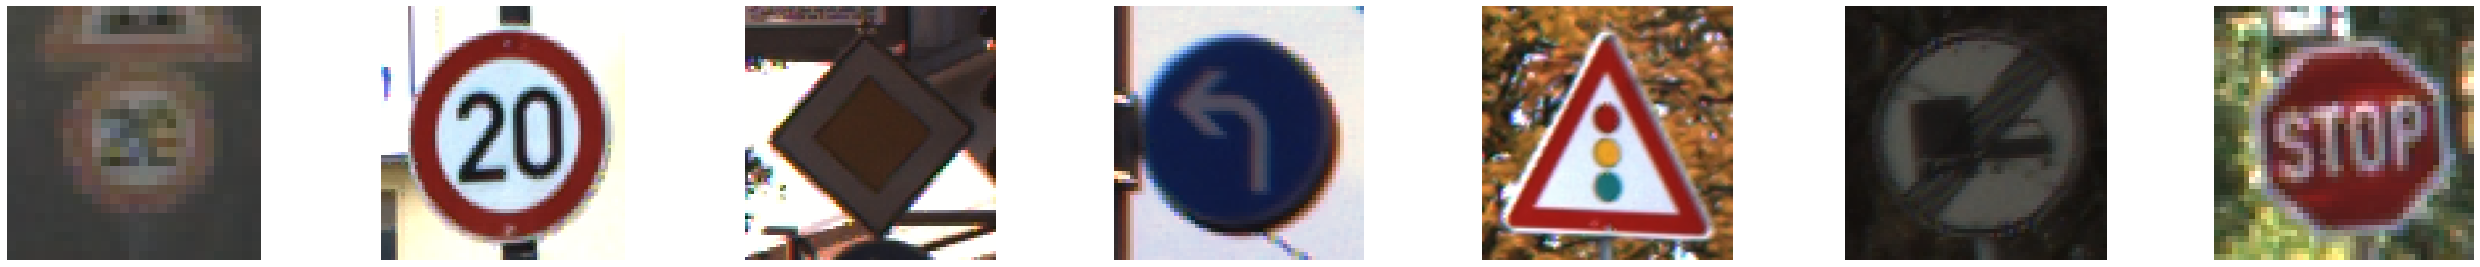

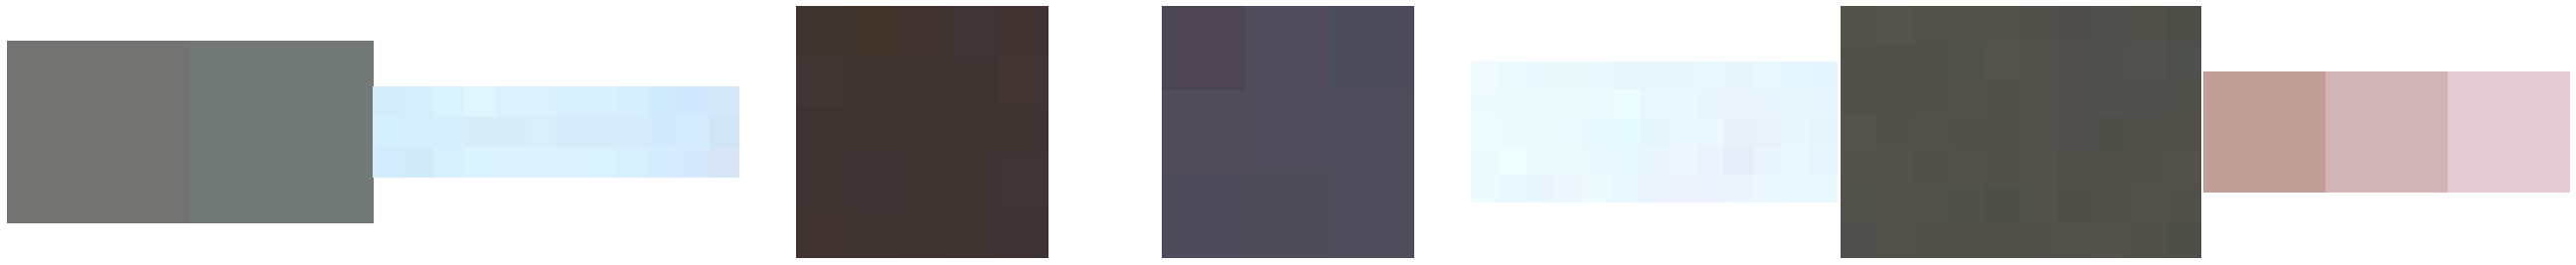

-difference to R=G=B
 -image 0: 3.5
 -image 1: 37.611111111111114
 -image 2: 14.079999999999998
 -image 3: 15.111111111111114
 -image 4: 19.923076923076934
 -image 5: 7.01428571428572
 -image 6: 29.333333333333314

illumination correction(mean)
 r_mode: 0.348, r_factor: 0.958, g_mode: 0.332, g_factor: 1.004
max r+g: 0.7709768211386179
138.6963171146385
 r_mode: 0.328, r_factor: 1.015, g_mode: 0.333, g_factor: 1.000
max r+g: 0.9174420462481302
258.8130287053902
 r_mode: 0.349, r_factor: 0.955, g_mode: 0.317, g_factor: 1.051
max r+g: 1.0
267.95614428532036
 r_mode: 0.304, r_factor: 1.096, g_mode: 0.334, g_factor: 0.997
max r+g: 0.884839830182749
279.54698256172026
 r_mode: 0.333, r_factor: 1.000, g_mode: 0.330, g_factor: 1.009
max r+g: 1.0
257.22083549767365
 r_mode: 0.352, r_factor: 0.948, g_mode: 0.332, g_factor: 1.003
max r+g: 0.7809047559492978
85.29537607390601
 r_mode: 0.348, r_factor: 0.959, g_mode: 0.340, g_factor: 0.980
max r+g: 0.8563424863982808
270.4405091953621


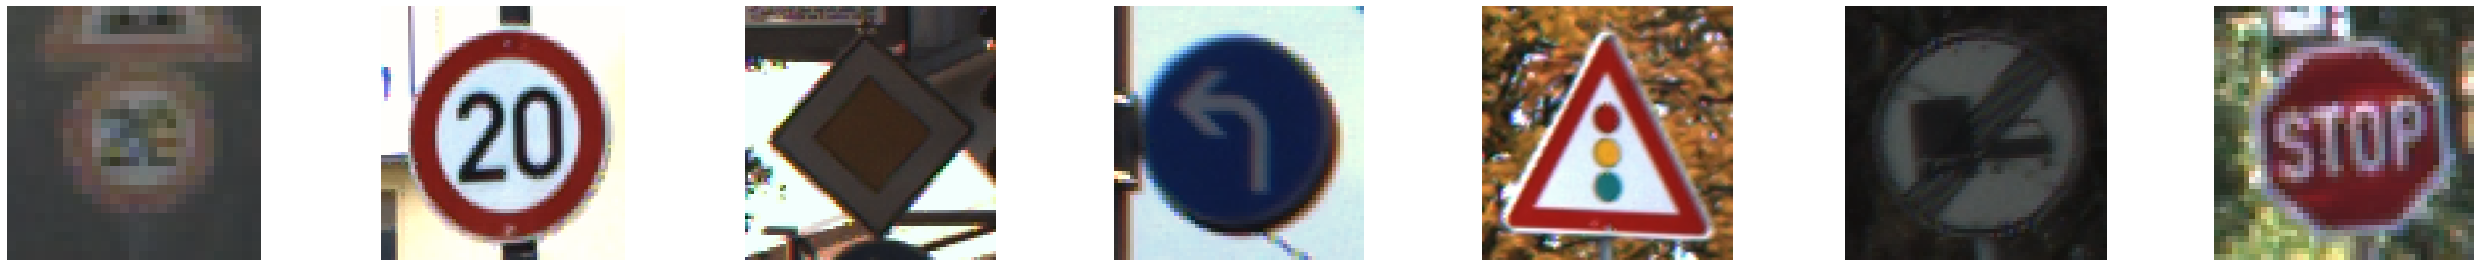

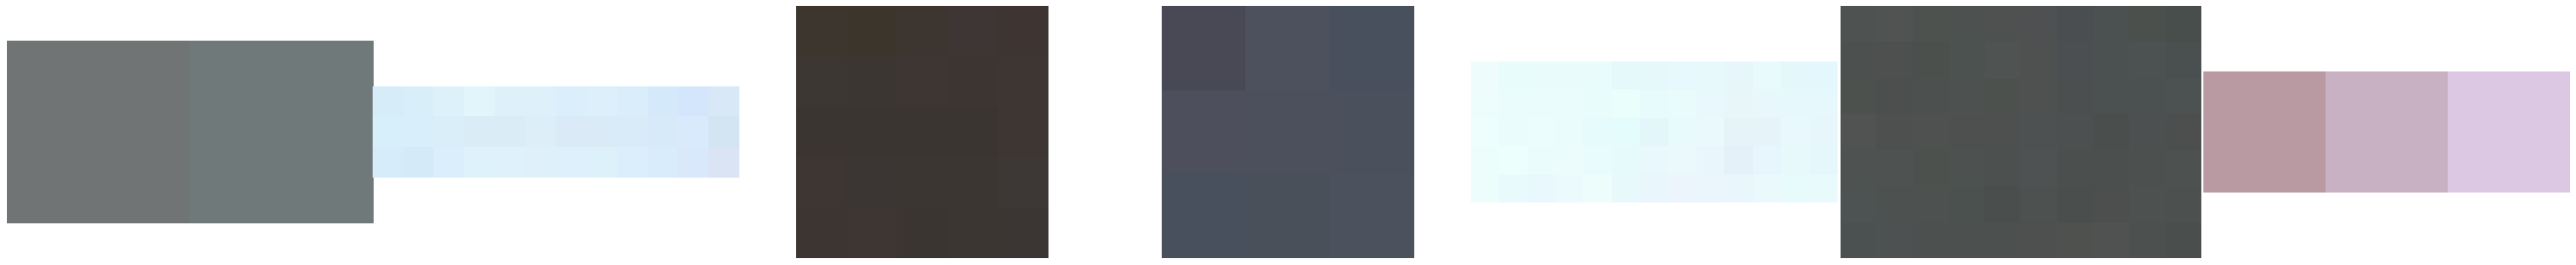

-difference to R=G=B
 -image 0: 7.5
 -image 1: 31.611111111111114
 -image 2: 10.079999999999998
 -image 3: 17.111111111111114
 -image 4: 18.938461538461553
 -image 5: 4.085714285714289
 -image 6: 24.666666666666657
normalized_r:


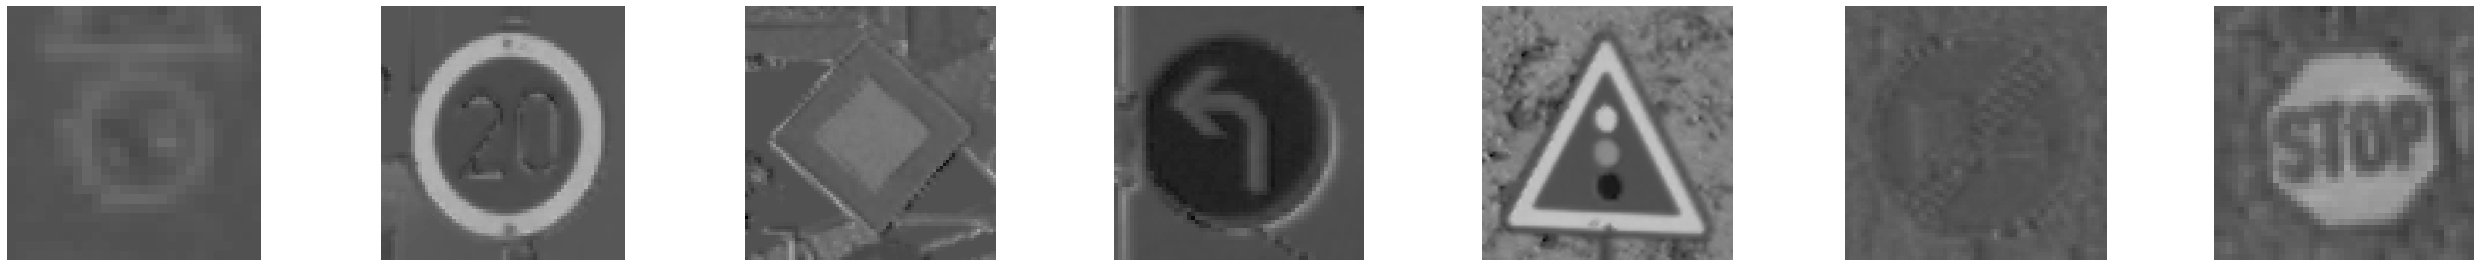

normalized_g:


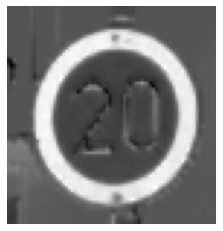

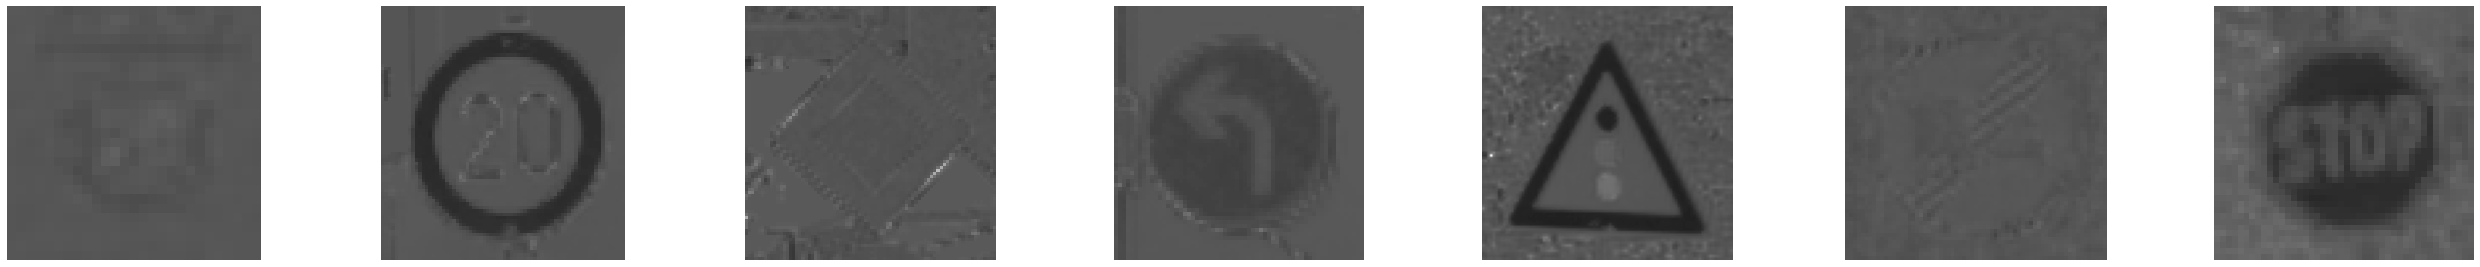

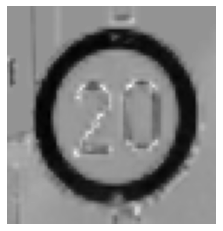

In [5]:
def find_mode(values, exp_mode, delta, prec=0.01,  verbose=False):
    """ returns mode in [exp_mode-delta, exp_mode+delta] """
    # sort values and use only range +-delta
    values = np.sort(values.reshape(-1))
    values = values[np.logical_and(values > exp_mode - delta,values < exp_mode + delta)]    
    # create histogram and smooth
    hist = np.histogram(values, int((np.max(values)-np.min(values))/prec))
    smoothed_hist = ndimage.gaussian_filter1d(hist[0], sigma = 0.1)
    # get argmax
    mode = hist[1][np.argmax(smoothed_hist)]
    return mode

def find_mean(values, exp_mode, delta, verbose=False):
    """ returns mean in [exp_mode-delta, exp_mode+delta] """
    # sort values and use only range +-delta
    values = np.sort(values.reshape(-1))
    values = values[np.logical_and(values > exp_mode - delta,values < exp_mode + delta)]    
    mode = np.mean(values)
    return mode


def color_constancy_correction_rg(img_rg, test = False, verbose=False):
    '''
    Color correction in the normalized rg space
        Assumption: 
            * the normalized color values have a mode at 1/3, 1/3 (white, gray, black areas)
            * the mode is only slightly shifted (max 0.05)
            * image can be corrrected by finding a factor that is muliplyed with all values
              such that the mode is then at (1/3 1/3)
        Method:
            * the mode of the normalized rg values closest to 1/3 1/3 is searched,
            * a corrective factor is cacluated to shift the values from the curent mode to 1/3            
    '''
    if not test:
        r_mode = find_mode(img_rg[:,:,0], exp_mode=1/3, delta=0.05, prec=0.0005, verbose=verbose)# find current max in images
        g_mode = find_mode(img_rg[:,:,1], exp_mode=1/3, delta=0.05, prec=0.0005, verbose=verbose) # find current max in images
    else:
        r_mode = find_mean(img_rg[:,:,0], exp_mode=1/3, delta=0.05, verbose=verbose)
        g_mode = find_mean(img_rg[:,:,1], exp_mode=1/3, delta=0.05, verbose=verbose) 
    
    if verbose:
        print(" r_mode: %0.3f, r_factor: %0.3f, g_mode: %0.3f, g_factor: %0.3f"%(r_mode, 1/3/r_mode, g_mode, 1/3/g_mode))
    rg_c = np.zeros(img_rg.shape) # initializing the color corrected image
    rg_c[:,:,0] = img_rg[:,:,0] * 1/3 * 1/r_mode # shift current r-mode to 1/3
    rg_c[:,:,1] = img_rg[:,:,1] * 1/3 * 1/g_mode # shift current g-mode to 1/3
    # sifting could lead to too high values - clip
    sum_rg = rg_c[:,:,0]+rg_c[:,:,1]
    rg_c[:,:,0][sum_rg > 1] = (rg_c[:,:,0] - ((sum_rg-1)/2))[sum_rg > 1] # sum should be max = 1
    rg_c[:,:,1][sum_rg > 1] = (rg_c[:,:,1] - ((sum_rg-1)/2))[sum_rg > 1] # sum should be max = 1
    print("max r+g:", np.max(rg_c[:,:,0]+rg_c[:,:,1]))
    return rg_c


'''
transforms input to normalized rg
    x: np nd-array wit HeightxWidthxColor(rg space 2 channel)
''' 
def rgToRGB(x, intensity):
    img = np.zeros((x.shape[0],x.shape[1],3))
    img[:,:,:2] = x
    img[:,:,2] = 1- (x[:,:,0]+x[:,:,1])
    img = (img*intensity)
    print(np.max(img))
    img[img>255] = 255
    return img.astype(np.uint8)

print("input image")
plot_images(images)
plot_images([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i,img in enumerate(images)])
print("-difference to R=G=B")  
for i,gt_img in enumerate([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i, img in enumerate(images)]):
    mean = np.mean(gt_img, axis=(0,1))
    print(F" -image {i}: {np.max(mean) - np.min(mean)}")

print('')
print("illumination correction(mode):")
images_cc = []
rg_images = []
for img in images:
    img_rg = normalizedRG(img)
    rg_corrected = color_constancy_correction_rg(img_rg, False, True)
    #rg_images.append(normalizedRG(rgToRGB(rg_corrected, img.sum(axis =2, keepdims = True)))) #old
    images_cc.append(rgToRGB(rg_corrected, img.sum(axis =2, keepdims = True)))
plot_images(images_cc, RGB= True)
plot_images([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i,img in enumerate(images_cc)])
print("-difference to R=G=B")  
for i,gt_img in enumerate([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i, img in enumerate(images_cc)]):
    mean = np.mean(gt_img, axis=(0,1))
    print(F" -image {i}: {np.max(mean) - np.min(mean)}")

print('')
print("illumination correction(mean)")
images_cc = []
for img in images:
    img_rg = normalizedRG(img)
    rg_corrected = color_constancy_correction_rg(img_rg, True, True)
    rg_images.append(rg_corrected)
    images_cc.append(rgToRGB(rg_corrected, img.sum(axis =2, keepdims = True)))
plot_images(images_cc, RGB= True)
plot_images([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i,img in enumerate(images_cc)])
print("-difference to R=G=B")  
for i,gt_img in enumerate([img[gt[i][0][1]:gt[i][1][1], gt[i][0][0]:gt[i][1][0]] for i, img in enumerate(images_cc)]): 
    mean = np.mean(gt_img, axis=(0,1))
    print(F" -image {i}: {np.max(mean) - np.min(mean)}")
    

print("normalized_r:")
plot_images([img[:,:,0] for img in rg_images])
plt.axis('off')
plt.imshow(rg_images[1][:,:,0], cmap="gray")
print("normalized_g:")
plot_images([img[:,:,1] for img in rg_images])
plt.axis('off')
plt.imshow(rg_images[1][:,:,1], cmap="gray")

## Noise Estimation
Based on:
Shen-Chuan Tai and Shih-Ming Yang, "A fast method for image noise estimation using Laplacian operator and adaptive edge detection," 2008 3rd International Symposium on Communications, Control and Signal Processing, Saint Julian's, Malta, 2008, pp. 1077-1081, doi: 10.1109/ISCCSP.2008.4537384.

with the addition that areas with very strong or very weak saturation or intensity are not used.

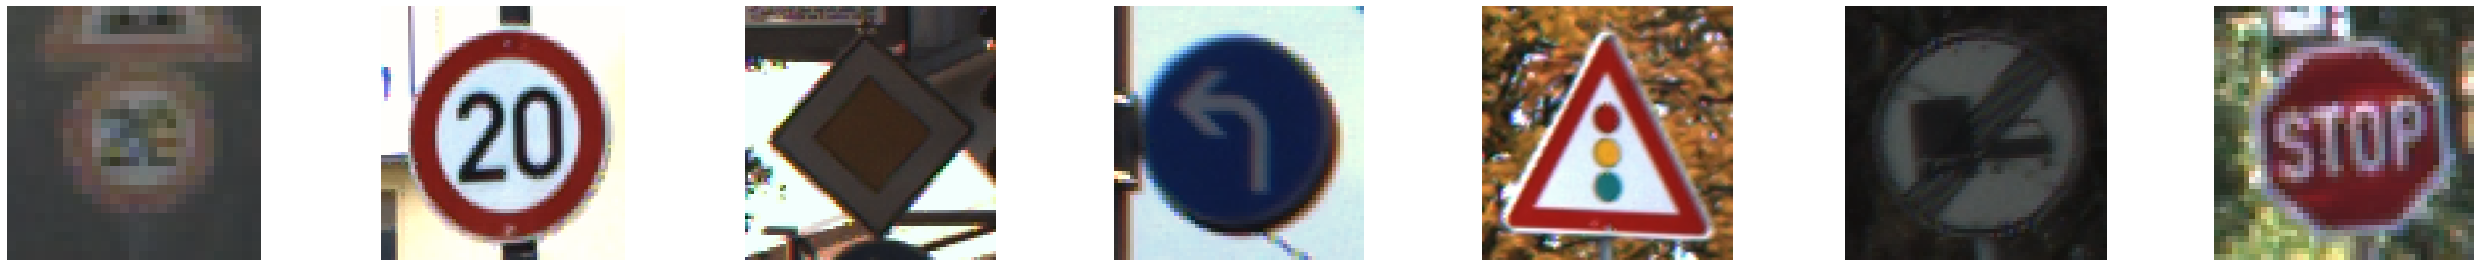

image 0 estimated noise(sigmas):0.78,0.88,0.89
image 1 estimated noise(sigmas):1.42,0.82,1.03
image 2 estimated noise(sigmas):0.85,0.93,0.92
image 3 estimated noise(sigmas):0.77,0.66,0.80
image 4 estimated noise(sigmas):2.20,1.38,1.53
image 5 estimated noise(sigmas):1.05,0.93,1.18
image 6 estimated noise(sigmas):2.68,1.84,1.87


In [6]:
def homogeneous_regions(img, images, p = 0.1, cutoff = False):
    '''
    returns a mask, for all pixels, if it is homogeneous
        p: omogenety is decided adaptively: p % of pixels with least of the edges
        cutoff: decides if very high(>95%) and low (<5%) saturation an intensity areas are filtered out
    '''
    S1 = [[-1,-2, -1],
          [ 0, 0, 0],
          [ 1, 2, 1]]

    S2 = [[-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]]
    I = images.sum(axis =2)
    min_c = (np.minimum(np.minimum(images[:,:,0], images[:,:,1]),images[:,:,2]))
    S = 1- np.divide(min_c, I, out= np.zeros(min_c.shape), where=I!=0)
    g1 = np.absolute(signal.convolve2d(img, S1, mode = 'same'))
    g2 = np.absolute(signal.convolve2d(img, S2, mode = 'same'))
    g = g1 +g2
    if cutoff:
        #dont use positions with high and low intensity I>0.05*255*3 and I< 0.95*255*3
        g[I>0.95*255*3] = g.max()
        g[I<0.05*255*3] = g.max()
        #dont use positions with high and low sturation S>0.05 and S< 0.95
        g[S>0.95] = g.max()
        g[S<0.05] = g.max()
    if (g.max() == g.min()):
        threshhold_g = g.min()
    else:
        hist_g = np.histogram(g, g.max()-g.min(),(g.min(),g.max()))
        threshhold_g, p_pixels = g.min(), p*img.shape[0]*img.shape[1]
        sum_pixels = 0
        for gi, g_value in enumerate(hist_g[0]):
            sum_pixels += g_value
            if sum_pixels > p_pixels:
                threshhold_g = g.min()+gi
                break
    #print("min: %i, max %i, threshold: %i"%(g.min(), g.max(),threshhold_g))
    masked_img = np.ma.masked_where(g>threshhold_g, img)
    return masked_img


def estimateNoise(images, verbose = False, cutoff = True):
    ''' 
    Gaussian noise estimation  
    based on 'A fast method for image noise estimation using Laplacian operator and adaptive edge detection'
    by Tai and Yang
    '''
    sigmas=[]
    for img in [images[:,:,0],images[:,:,1],images[:,:,2]]:
        H, W = img.shape
        
        # Laplacian operator to suppresses the image structures
        M = [[1, -2, 1], 
            [-2, 4, -2],
            [1, -2, 1]]
        suppressed_img = signal.convolve2d(img, M, mode='valid')
        
        # Calculate variance of homogenous regions, assume these are noise
        img_mask = homogeneous_regions(img, images, cutoff= cutoff).mask[1:-1,1:-1]
        abs_values = np.ma.array(np.absolute(suppressed_img), mask = img_mask)
        sigma = np.sum(np.ma.sum(abs_values)) 
        N = (img_mask.shape[0]*img_mask.shape[1]) - np.count_nonzero(img_mask)
        if verbose:
            plot_images_scaled([img, img_mask, abs_values.data* np.invert( img_mask)])
            plt.hist(abs_values.data* np.invert( img_mask))
            plt.show()
        sigmas.append(sigma * math.sqrt(0.5 * math.pi) / (6 * N))
    return sigmas

plot_images(images_cc)
for i,img in enumerate(images_cc):
    sigma = estimateNoise(img)
    print("image %i estimated noise(sigmas):%.2f,%.2f,%.2f"%(i,sigma[0],sigma[1],sigma[2]))
    
    

## Noise Propagation
Distribution of observed values $\hat{r}, \hat{g}$
$$P_1 =\left(\begin{array}{c} \hat{r}\\\hat{g} \end{array}\right)
\sim N\left(\boldsymbol{\mu_{\hat{r},\hat{g}}},\Sigma_{\hat{r},\hat{g}}\right)$$

with 
	$ \boldsymbol{\mu_{\hat{r},\hat{g}}} = \left(\begin{array}{c} r\\g\end{array}\right)$

The variance and covariance could be calculated by linear covariance propagation as done by Greiffenhagen, leading to the following covariance matrix:

$\Sigma_{\hat{r},\hat{g}}=\frac{\sigma_I^2}{S^2}\left(\begin{array}{cc}
\frac{\sigma^2_R}{\sigma_I^2}(1-\frac{2R}{S})+3\frac{R^2}{S^2}&
-\frac{\sigma^2_G R+\sigma_R^2G}{\sigma_I^2S}+3\frac{RG}{S^2}\\
-\frac{\sigma^2_G R+\sigma_R^2G}{\sigma_I^2S}+3\frac{RG}{S^2}&
\frac{\sigma^2_G}{\sigma_I^2}(1-\frac{2G}{S})+3\frac{G^2}{S^2}\\
\end{array}\right)$

$S=R+G+B$, $\sigma_I^2=\frac{\sigma_S^2}{3}=\frac{\sigma_R^2+\sigma_G^2+\sigma_B^2}{3}$

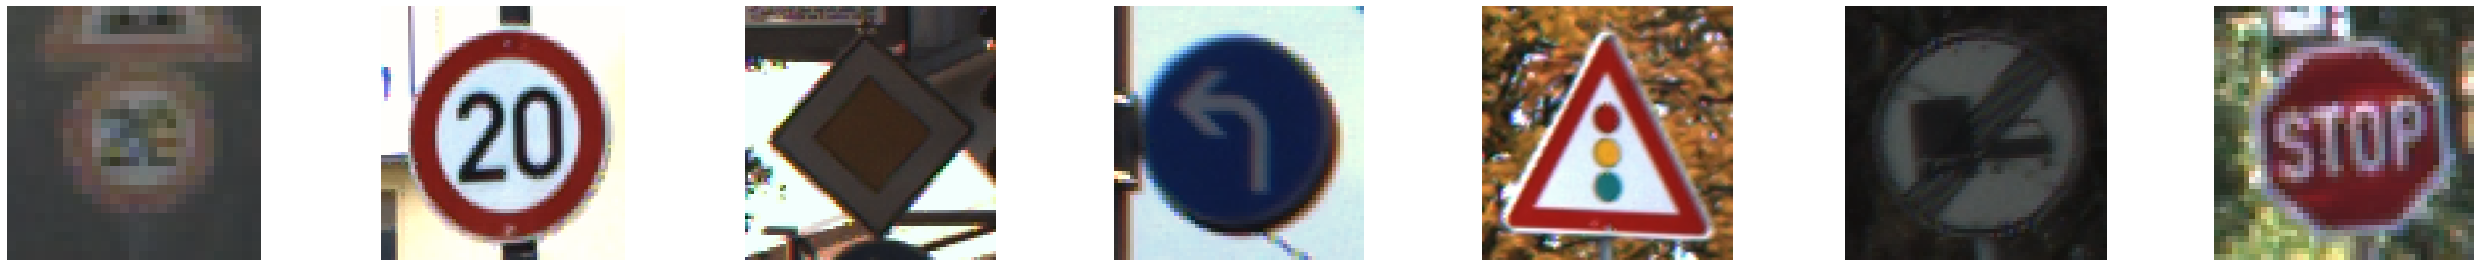

var_r:


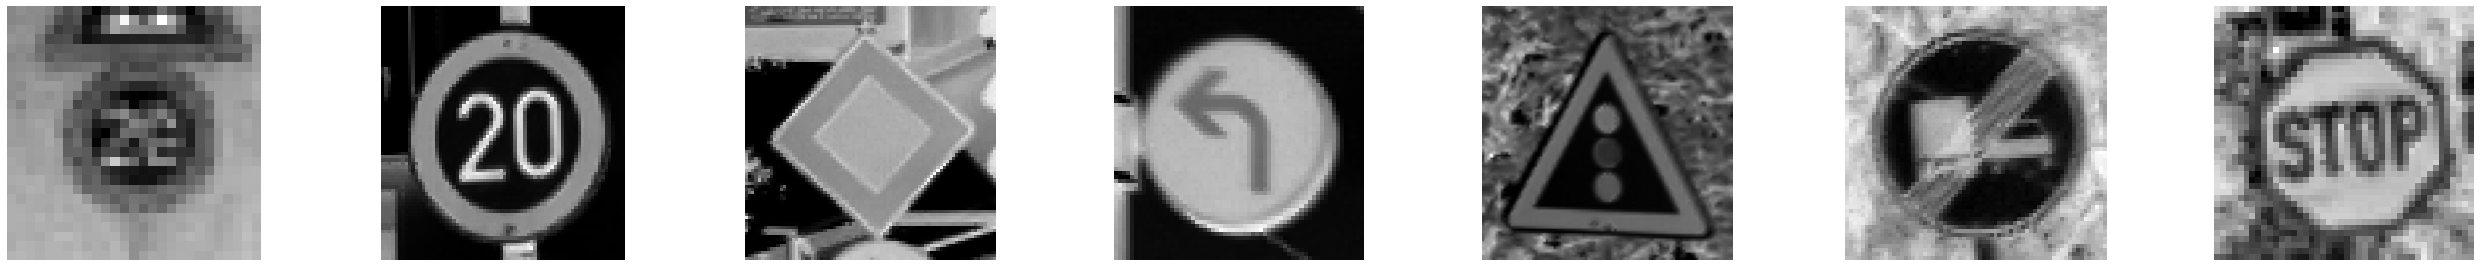

var_g:


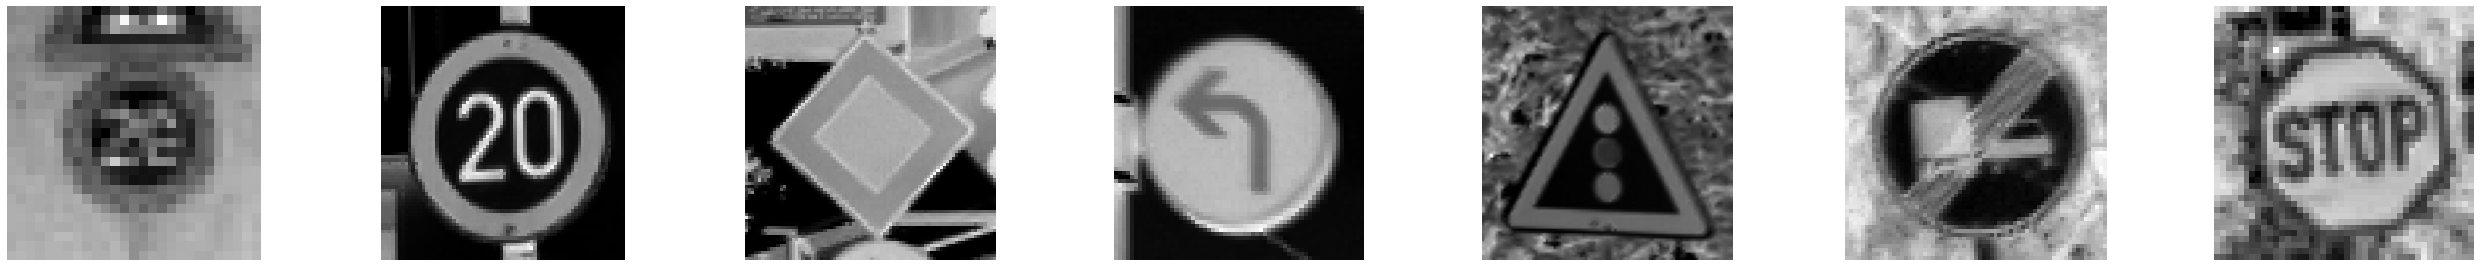

-cov(r,g):


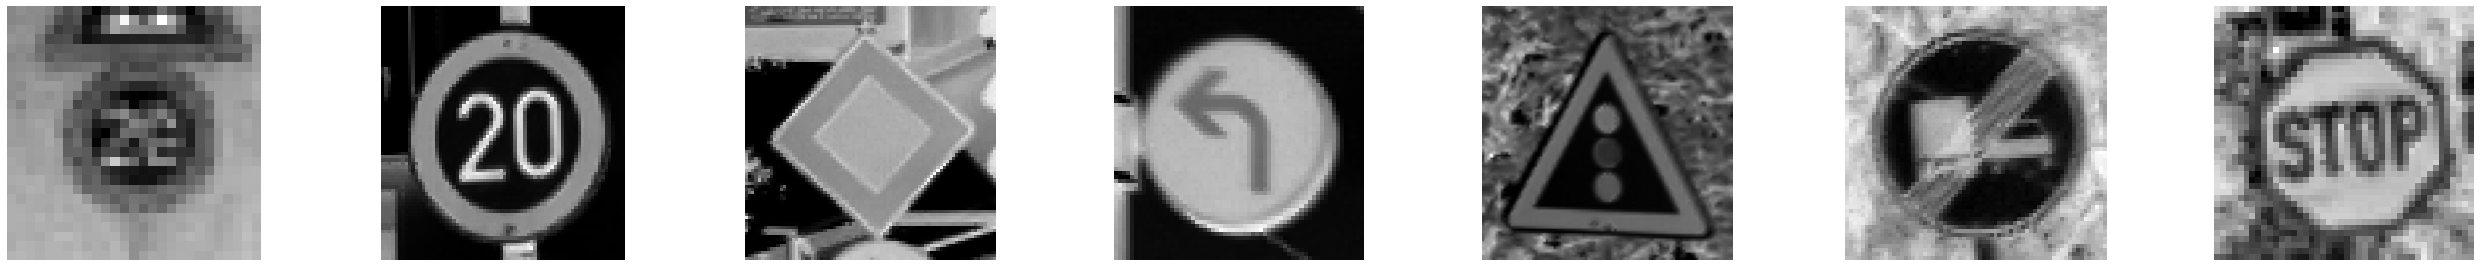

In [7]:
def cov(img, sigma, r,g):
    '''
    calculation of the covariance matrix based on Greiffenhagen
        sigma: estimated gaussian noise per color channel
    '''
    var_R = np.square(sigma[0])
    var_G = np.square(sigma[1])
    var_B = np.square(sigma[2])

    R = img[:,:,0].astype(np.float64)
    G = img[:,:,1].astype(np.float64)
    B = img[:,:,2].astype(np.float64)
    eps = 1
    S = R+G+B+eps
    eps = 1e-7
    var_I = ((var_R+var_G+var_B)/3)+eps

    var_r1 = (var_R/var_I)*(1-2*r)+3*r*r
    var_r = var_I/np.square(S)* var_r1

    var_g1 = (var_G/var_I)*(1-2*g)+3*g*g
    var_g = var_I/np.square(S)* var_g1
    
    cov_rg1= -((var_G/var_I)*r)-((var_R/var_I)*g)+3*r*g
    cov_rg = var_I/np.square(S)* cov_rg1 
    return np.array([[var_r,cov_rg],[cov_rg,var_g]])


cov_matrix =[]
for img in images_cc:
    cov_matrix.append(cov(img, estimateNoise(img), 1/3,1/3))

plot_images(images_cc)
print("var_r:")
plot_images([m[0,0] for m in cov_matrix], own_scale = True, lognorm = True)

print("var_g:")
plot_images([m[1,1] for m in cov_matrix], own_scale = True, lognorm = True)

print("-cov(r,g):")
plot_images([-m[0,1] for m in cov_matrix], own_scale = True, lognorm = True)

## Mahalanobis Distance

Distance between point $x= \left(\begin{array}{c} \hat{r}\\ \hat{g}\end{array}\right)$ and mean point $ \left(\begin{array}{c} r\\ g\end{array}\right)$ and cov_matrix $\Sigma$.

Where $\Sigma_\textbf{g}^{-1} = \frac{1}{\sigma_{r_\textbf{g}}^2\sigma_{g_\textbf{g}}^2-cov(r_\textbf{g}g_\textbf{g})^2}\left(\begin{array}{cc}
\sigma_{g_\textbf{g}}^2 & -cov(r_\textbf{g},g_\textbf{g})\\
-cov(r_\textbf{g},g_\textbf{g}) & \sigma_{r_\textbf{g}}^2\\
\end{array}\right)$ 
and $r' = \hat{r}-r$, $g' = \hat{g}-g$

$\Rightarrow D_M(x)^2 =r'r' \Sigma_{\textbf{g}_{1,1}}^{-1} +2 r'g'\Sigma_{\textbf{g}_{1,2}}^{-1} + g'g' \Sigma_{\textbf{g}_{2,2}}^{-1}$


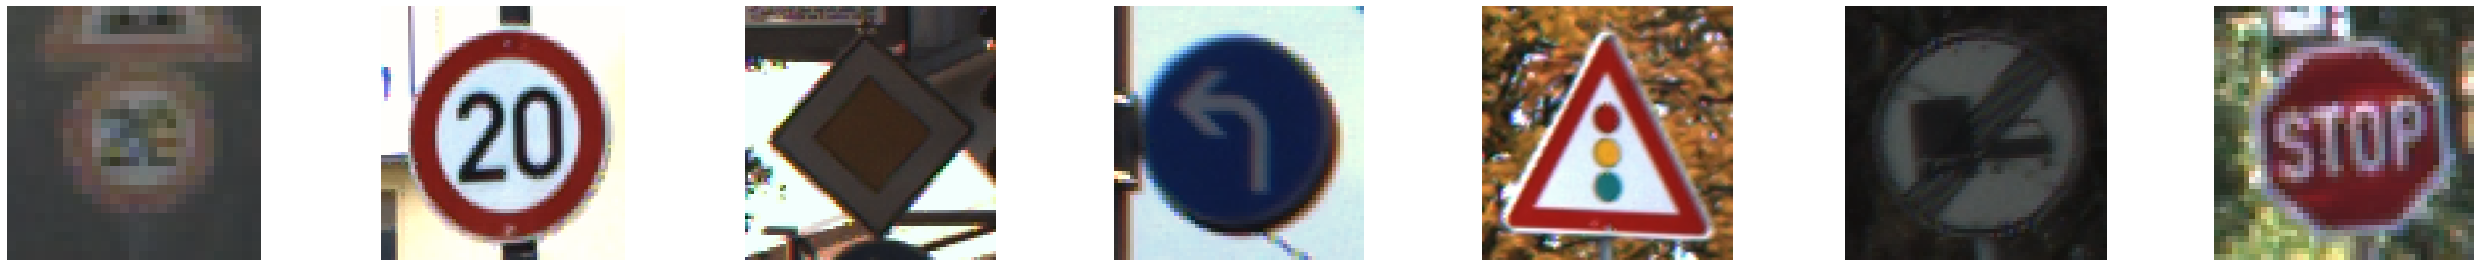

mahalanobi distance:


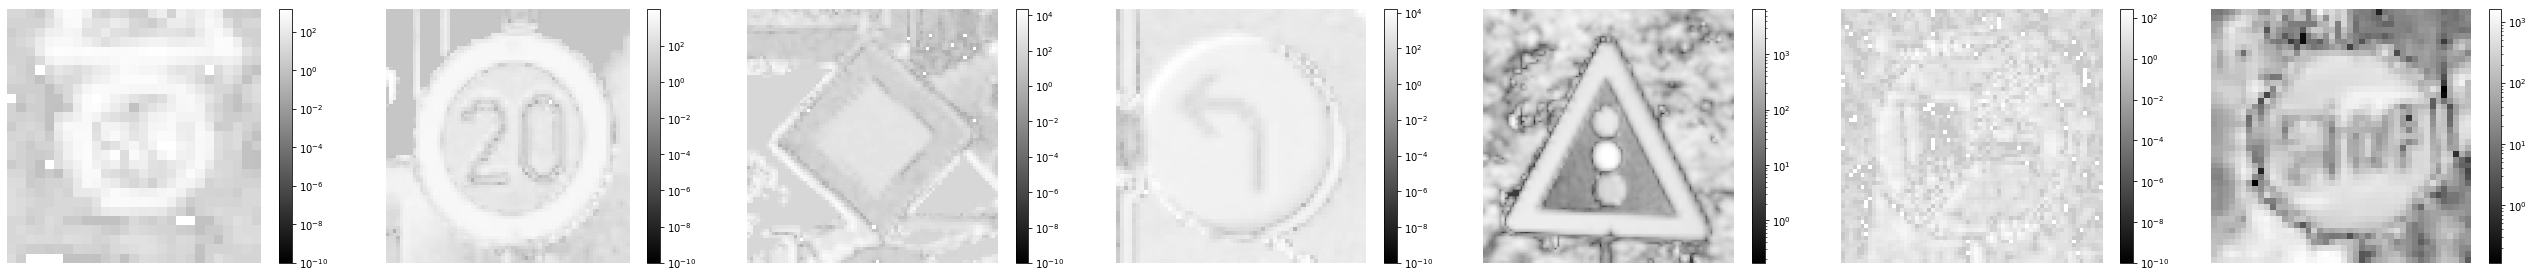

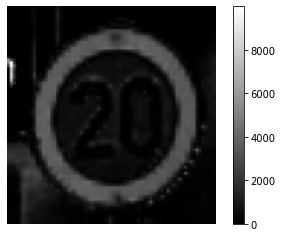

In [8]:
def mahalanobi_dist(rg_measurement, mean, img, sigma):
    eps = 1e-20
    r_mean,g_mean = mean
    cov_ma = cov(img, sigma, r_mean, g_mean)
    s_factor = 1/((cov_ma[0][0]*cov_ma[1][1])-np.square(cov_ma[0][1])+eps)
    s11 = s_factor * cov_ma[1][1]
    s12 = s_factor * - cov_ma[0][1]
    s22 = s_factor * cov_ma[0][0]
    inv_s =(s11+s22+s12) /3
    r_diff = rg_measurement[:,:,0]-r_mean
    g_diff = rg_measurement[:,:,1]-g_mean
    mah_dist =  r_diff*r_diff*s11+2*r_diff*g_diff*s12+g_diff*g_diff*s22
    return mah_dist

mah_distances =[]
for img in images_cc:
    rg = normalizedRG(img)
    mah_distances.append(mahalanobi_dist(rg, (1/3,1/3), img, estimateNoise(img)))

plot_images(images_cc)
print("mahalanobi distance:")
plot_images(mah_distances, own_scale = True, lognorm= True, colorbar =True)
plt.axis('off')
im = plt.imshow(mah_distances[1], cmap="gray")
plt.colorbar(im)

## Analyzing the Mahalanobis distance 

medians,  21.10,  399.34,  107.85,  1073.89,  722.76,  6.60,  134.44
means,  165.13,  938.35,  439.00,  1536.15,  1020.57,  12.40,  225.96
vars,  67849.01,  1538460.29,  1142210.70,  2434189.96,  964859.38,  327.09,  58460.34


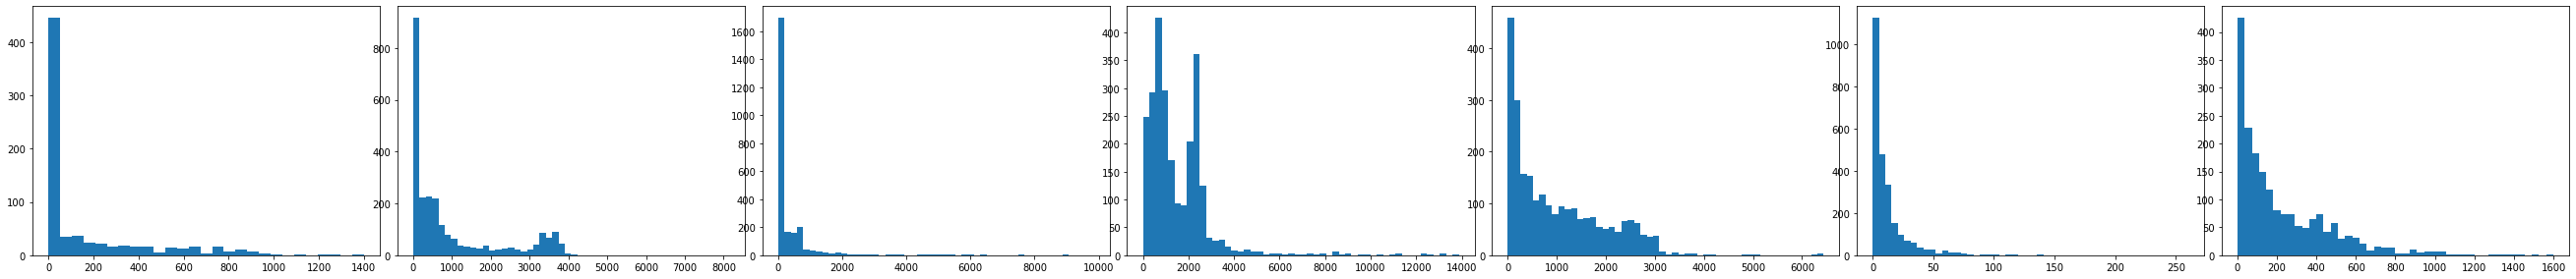

log range:


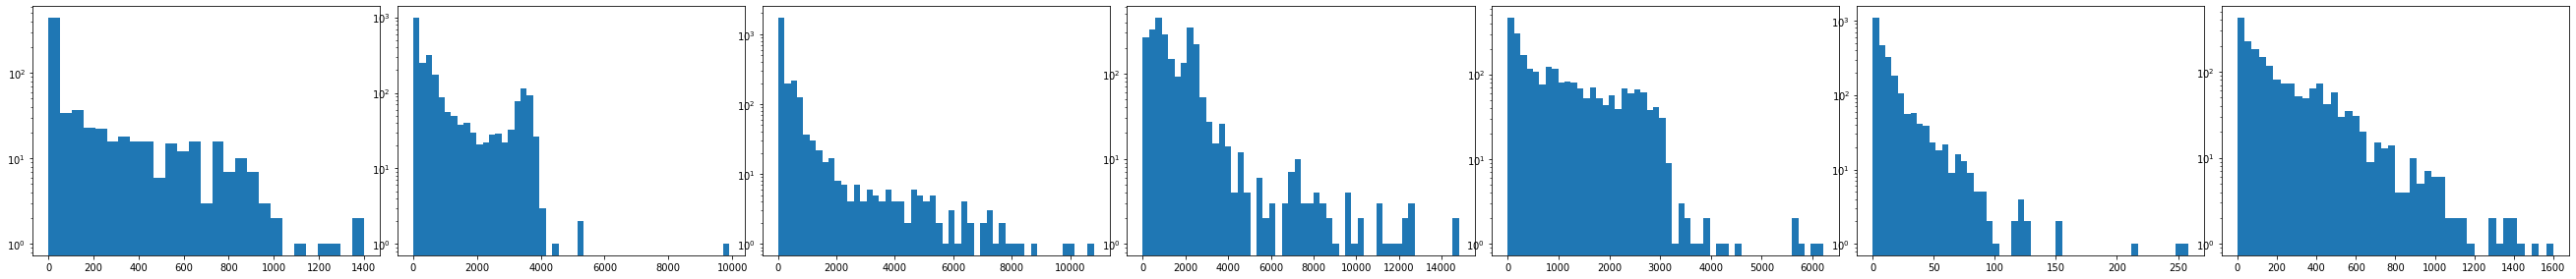

Text(0.5, 0, 'squared Mahalanobis distance')

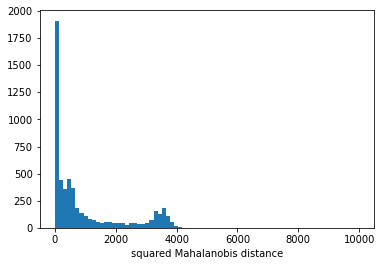

In [16]:
def print_float_list(values, name):
    print(name, end ="")
    l =["%0.2f"%(i) for i in values]
    for i in range(len(l)):
        print(", ",l[i], end ="") 
    print("")
    
def plot_hists(images,range = None,  size=(5.5,4), bins='sqrt', cum =False, horiz = True, log =False, max_plot_values = 2500):
    if horiz:
        fig, axs = plt.subplots(1, len(images), figsize=(size[0]*len(images), size[1]))
    else:
        fig, axs = plt.subplots(len(images),1 , figsize=(size[1],size[0]*len(images)))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    '''if range == None:
        max_range = 0
        for i in images:
            if i.max()>max_range:
                max_range = i.max()
        range =(0,max_range)'''
    for img, ax in zip(images ,axs.ravel()):
        if len(img) > max_plot_values:
            img = img[np.random.choice(len(img), size=max_plot_values)]
        im = ax.hist(img, bins = bins, range = range, log = log)
        if cum :
            ax.hist(img, bins = bins, range = range, cumulative=True, histtype='step', log = log)
    plt.show()     
    
print_float_list([np.median(m) for m in mah_distances], "medians")
print_float_list([m.mean() for m in mah_distances], "means")
print_float_list([m.var() for m in mah_distances], "vars")
plot_hists([np.reshape(m, (-1)) for m in mah_distances])
print("log range:")
plot_hists([np.reshape(m, (-1)) for m in mah_distances], log = True)

plt.hist(np.reshape(mah_distances[1], (-1)), bins='sqrt')
plt.xlabel('squared Mahalanobis distance')


## Confidence calculation with Bayes:
With observed Mahalanobis distance $d$, with null hypothesis $H_0$ : the pixel is not
colored and alternative hypothesis $H_1$: Pixel is colored:
$$P(H_1 |d) = \frac{P(d|H_1)\cdot P(H_1)}{P(d)} = \frac{P(d|H_1)\cdot P(H_1)}{P(d|H_0)P(H_0) + P(d|H_1)P(H_1)}$$

In [10]:
# Set estimated priors
p_H1 = 0.5
p_H0 = 1-p_H1
print("P(H1)=",p_H1)
print("P(H0)=",p_H0)

P(H1)= 0.5
P(H0)= 0.5


### Estimate $P(d|H_1)$ and $P(d|H_0)$

The squared Mahalanobis distance d has a mixture distribution of non-central chi-square distribution with multiple lambdas:
$$\Rightarrow \text{ pdf of }P(d): \int_{\lambda_{min}}^{\lambda_{max}} \frac{1}{\lambda_ {max}-\lambda_{min}} f_\chi(d,2,\lambda)\text{d} \lambda $$

 ##### First and Second Moments
If d is a random variable with pdf $f(d)= \int_a^b \frac{1}{b-a}f_\chi(d,2,\lambda)  \text{ d}\lambda = \frac{1}{b-a} \int_a^b f_\chi(d,2,\lambda)  \text{ d}\lambda$, then:

$$(6): E(d) = 2+\frac{a+b}{2}$$


$$(7): Var(d) {=}=4+2(a+b)-\frac{1}{6}ab+\frac{1}{12}(a^2+b^2)$$


In [11]:
def moments_noncentral_chi(min_lambda,max_lambda):
    a = min_lambda
    b = max_lambda
    if b == 0:
        mu = 0
    else:
        mu = 1/(b-a)*((2*b+(b*b)/2)- (2*a+(a*a)/2))
    var = 4+2*(a+b)-1/6*a*b+1/12*(a*a+b*b)
    return mu, var

In [12]:
def posterior_H1_given_d(mah_dist, max_lambdaH0,min_lambda_H1, max_lambdaH1, p_H0 = p_H0, p_H1 = p_H1):
        min_lambdaH0 = 0
     
        mu_d_H0, var_d_H0 = moments_noncentral_chi(min_lambdaH0,max_lambdaH0)
        mu_d_H1, var_d_H1 = moments_noncentral_chi(min_lambda_H1,max_lambdaH1)

        p_d_H0 = stats.norm.pdf(mah_dist, mu_d_H0, np.sqrt(var_d_H0))
        p_d_H1 = stats.norm.pdf(mah_dist, mu_d_H1, np.sqrt(var_d_H1))
        out = np.full(p_d_H1.shape,0.5)
        out[mah_dist>mu_d_H0]=1
        p = np.divide((p_d_H1* p_H1),(p_d_H1* p_H1+ p_d_H0*p_H0), out= out, where= (p_d_H1* p_H1+ p_d_H0*p_H0)>1e-9)
        return p

### lambda choice
Multiple models(lambda values) are combined to cover several cases, as the colors in the image vary e.g. due different light color.

Different models (defined by the seperating lambda value) are testets to see which model models the colored vs non-colored areas best:

lambda: 0


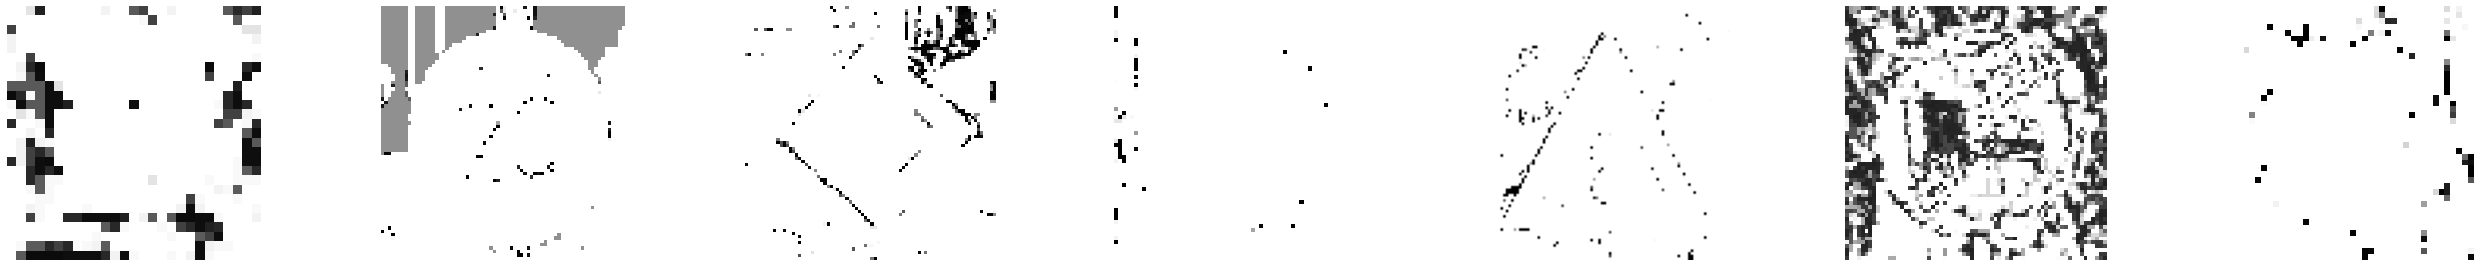

lambda: 1


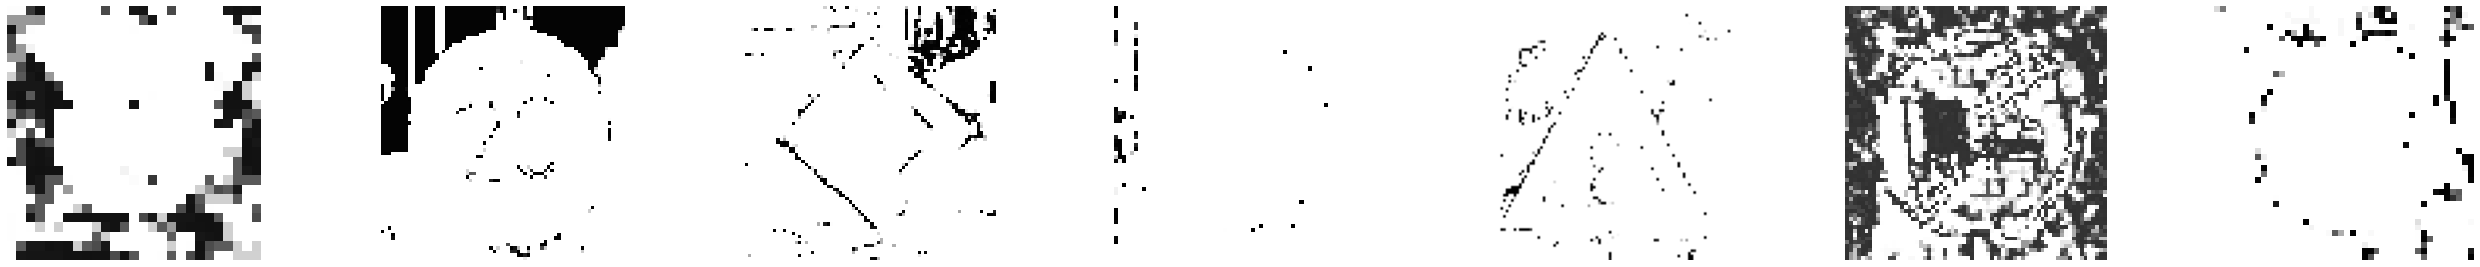

lambda: 10


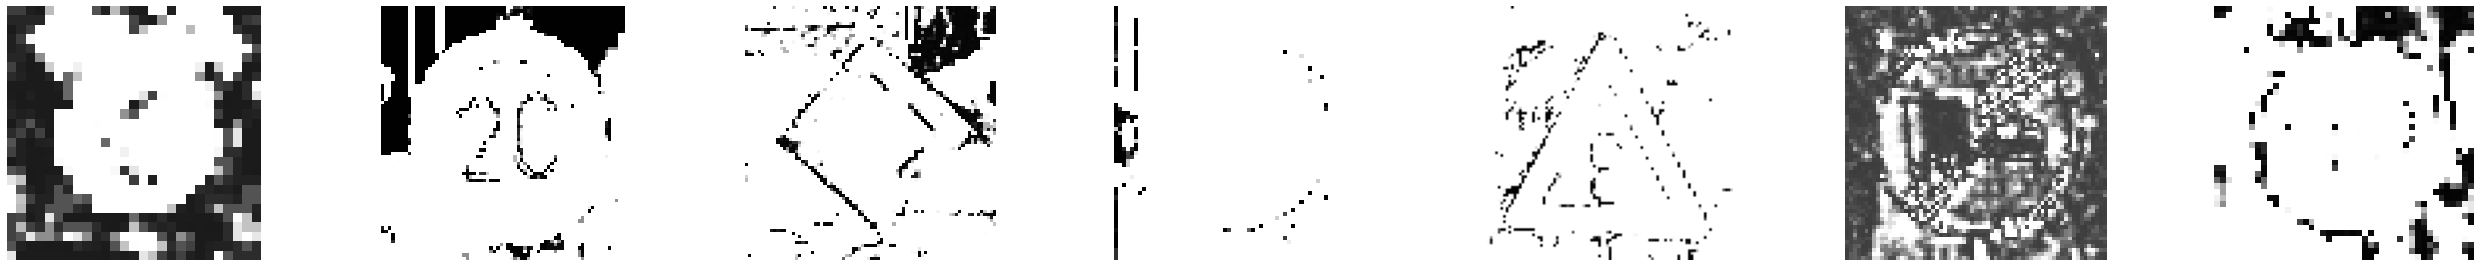

lambda: 1000


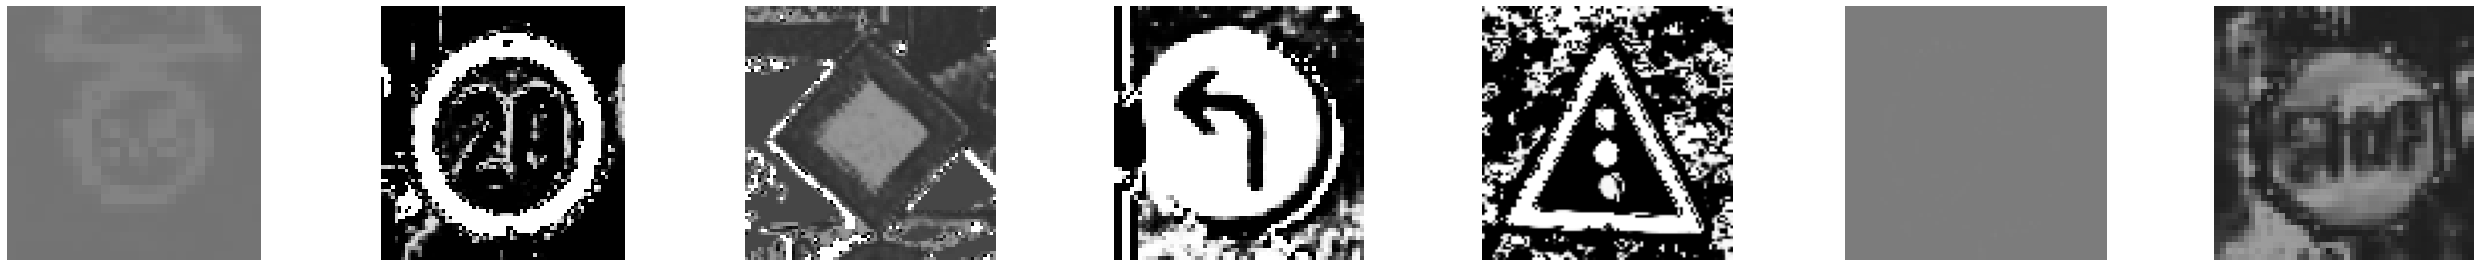

lambda: 0.10 percentile of trimmed mahalanobis distance


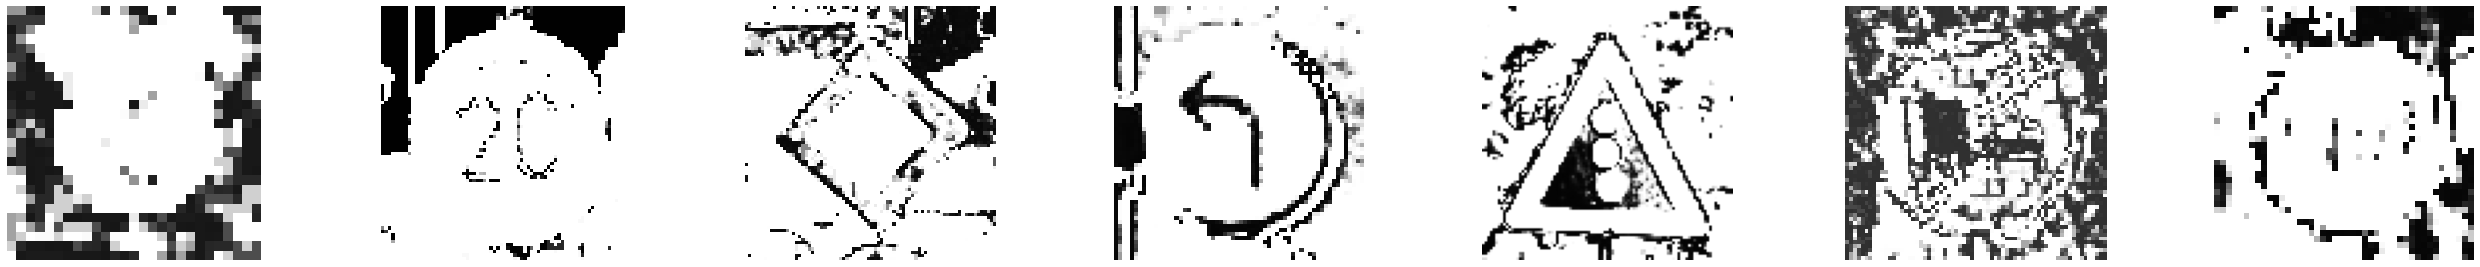

lambda: 0.25 percentile of trimmed mahalanobis distance


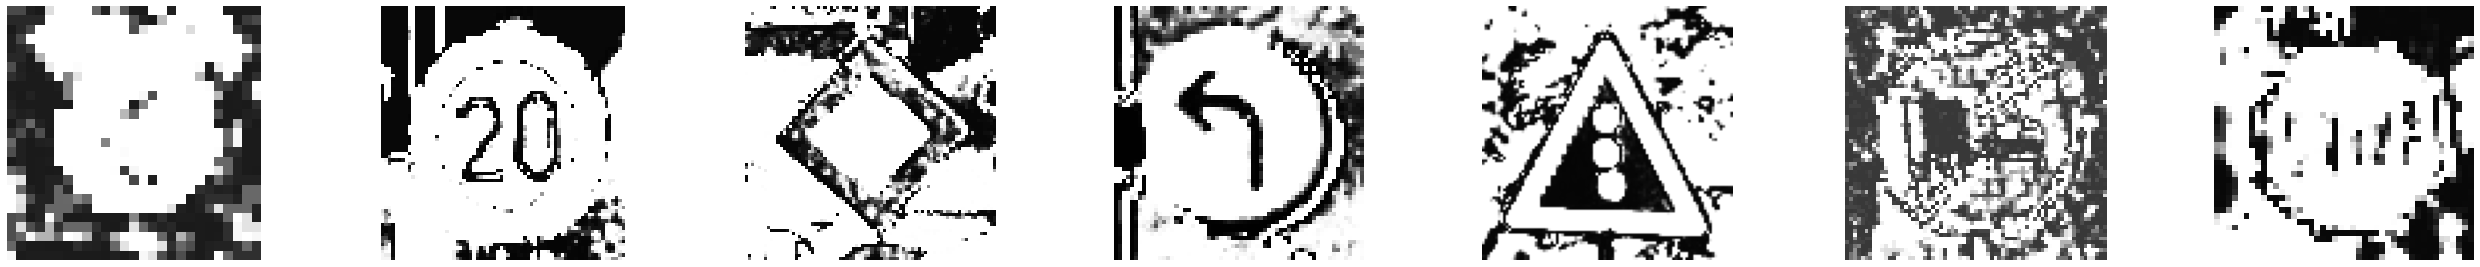

lambda: 0.50 percentile of trimmed mahalanobis distance


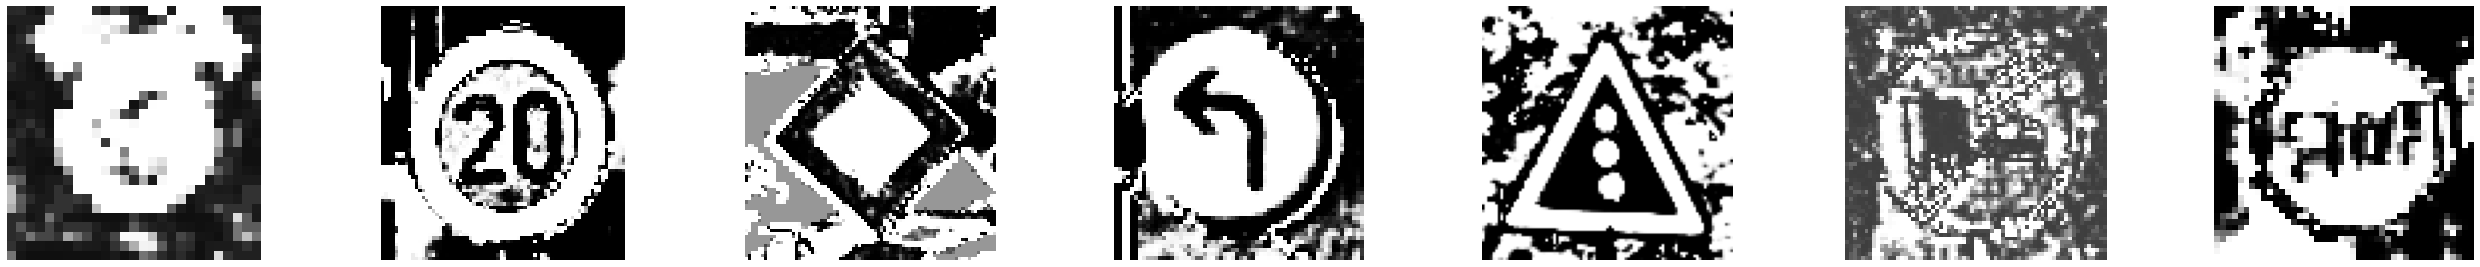

0.5 median


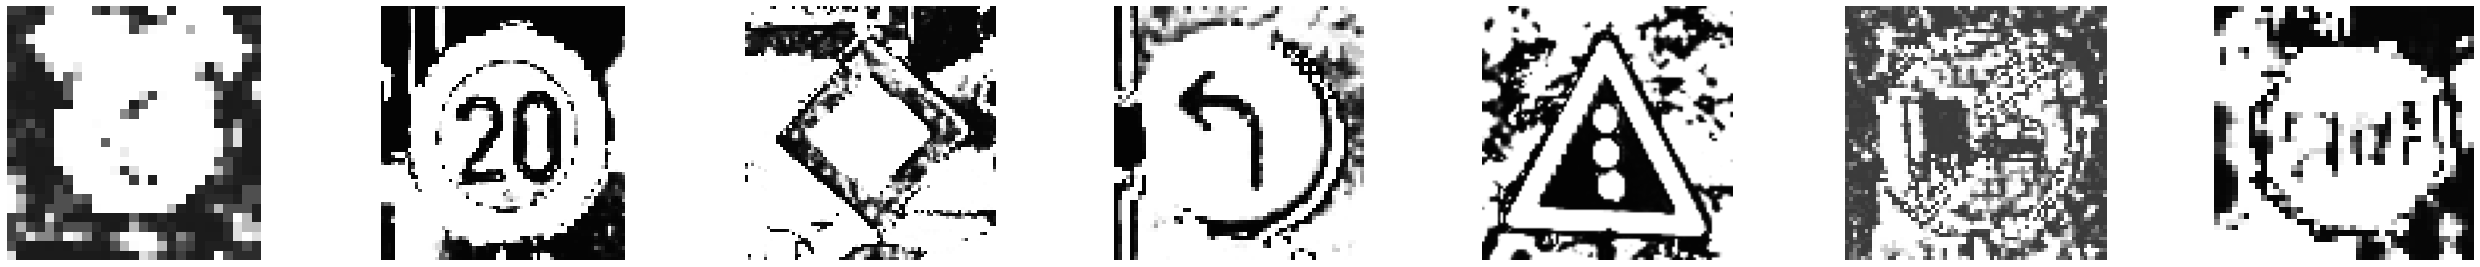

mixture of multiple confidences:


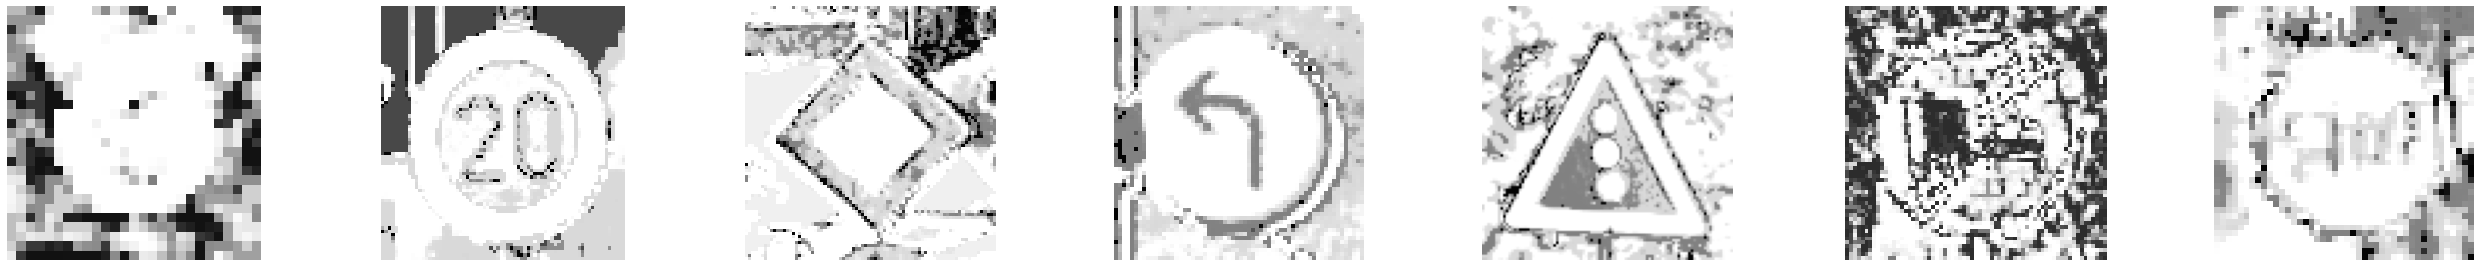

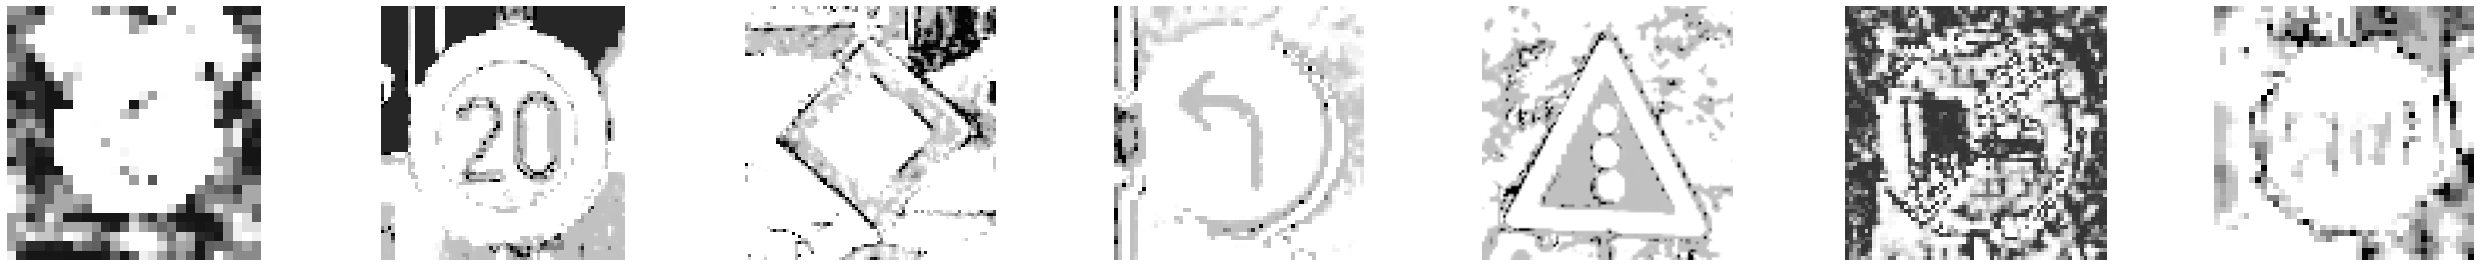

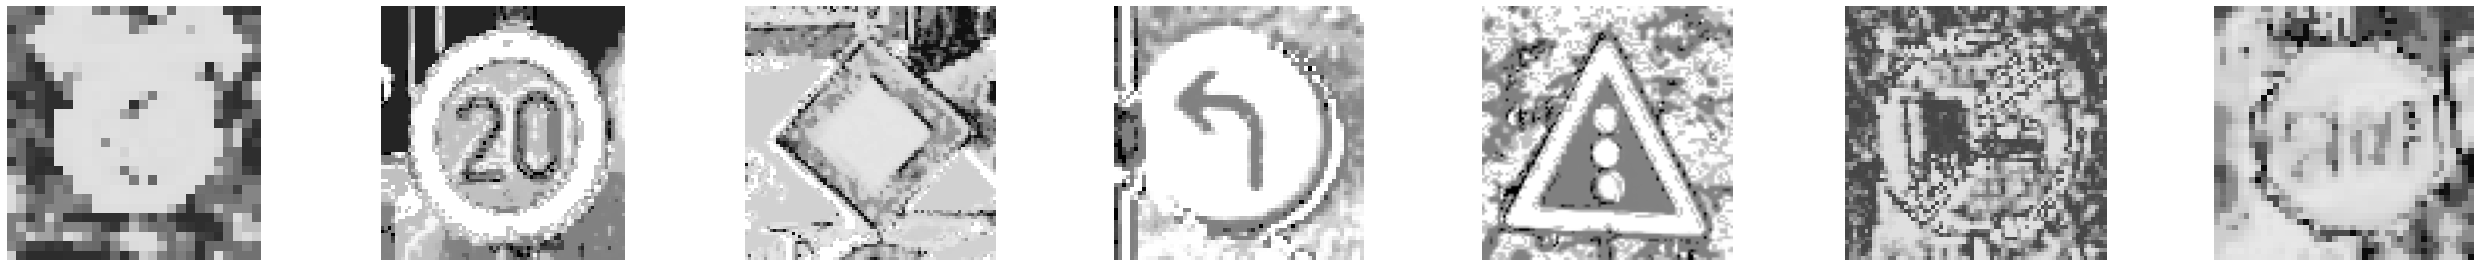

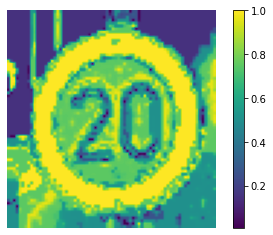

In [ ]:
confs=[]
percentiles = [0.1, 0.25,0.5]
lambdas = [0,1,10,1000]
for i, mah in enumerate(mah_distances):
    confs.append([])
    sorted_mah = np.sort(mah, axis = None)
    trimmed_mah = sorted_mah[int(len(sorted_mah)*0.05):-int(len(sorted_mah)*0.05)]
    for l in lambdas: #fixed values
        confs[i].append(posterior_H1_given_d(mah,l, l, np.median(trimmed_mah)*1.75))
    for perc in percentiles: # percentiles of trimmed values (for more robustness):
        l =  trimmed_mah[int(perc*len(trimmed_mah))]
        confs[i].append(posterior_H1_given_d(mah, l, l, np.median(trimmed_mah)*1.75))
    confs[i].append(posterior_H1_given_d(mah, 0.5*np.median(mah), 0.5*np.median(mah), np.median(trimmed_mah)*1.75))

for i in range(len(percentiles)+len(lambdas)+1):
    if i < len(lambdas):
        print("lambda:", lambdas[i])   
    elif i <len(lambdas)+len(percentiles):
        print("lambda: %.2f percentile of trimmed mahalanobis distance"%(percentiles[i-len(lambdas)]))
    else:
        print('0.5 median')
    plot_images([c[i] for c in confs])
    
print("mixture of multiple confidences:")
plot_images([0.5*c[0]+0.35*c[len(lambdas)]+0.15*c[len(lambdas)+2]  for c in confs])

plot_images([0.25*c[0]+0.25*c[1]+0.25*c[2]+0.25*c[len(lambdas)+len(percentiles)]  for c in confs])
plot_images([0.25*c[0]+0.25*c[2]+0.25*c[3]+0.25*c[len(lambdas)+len(percentiles)]  for c in confs])

plt.axis('off')
im = plt.imshow(0.25*confs[1][0]+0.25*confs[1][2]+0.25*confs[1][3]+0.25*confs[1][len(lambdas)+len(percentiles)])
plt.colorbar(im)
    

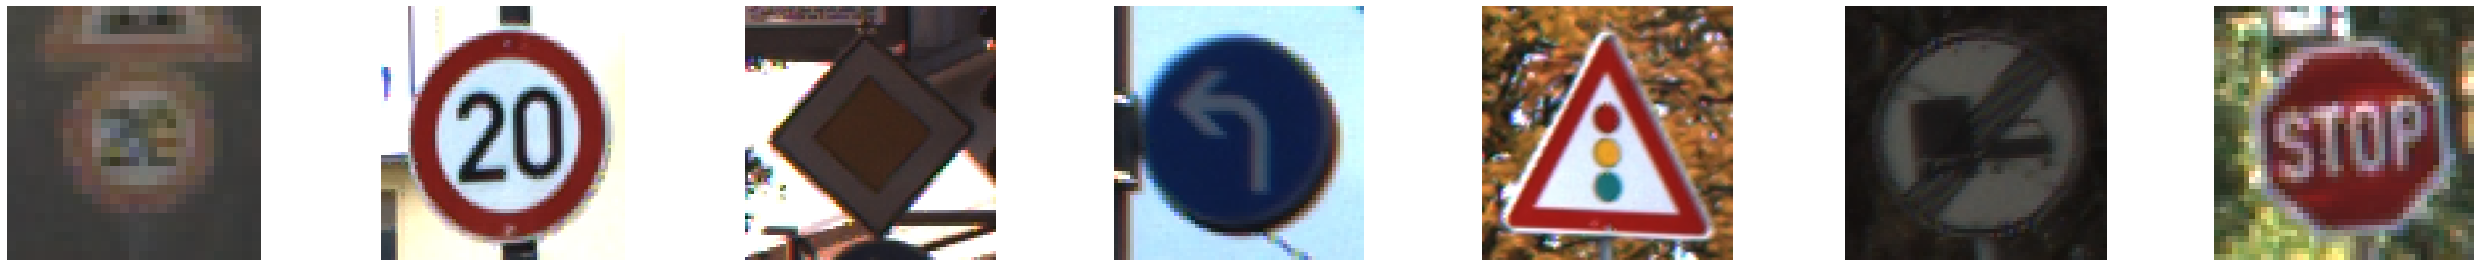

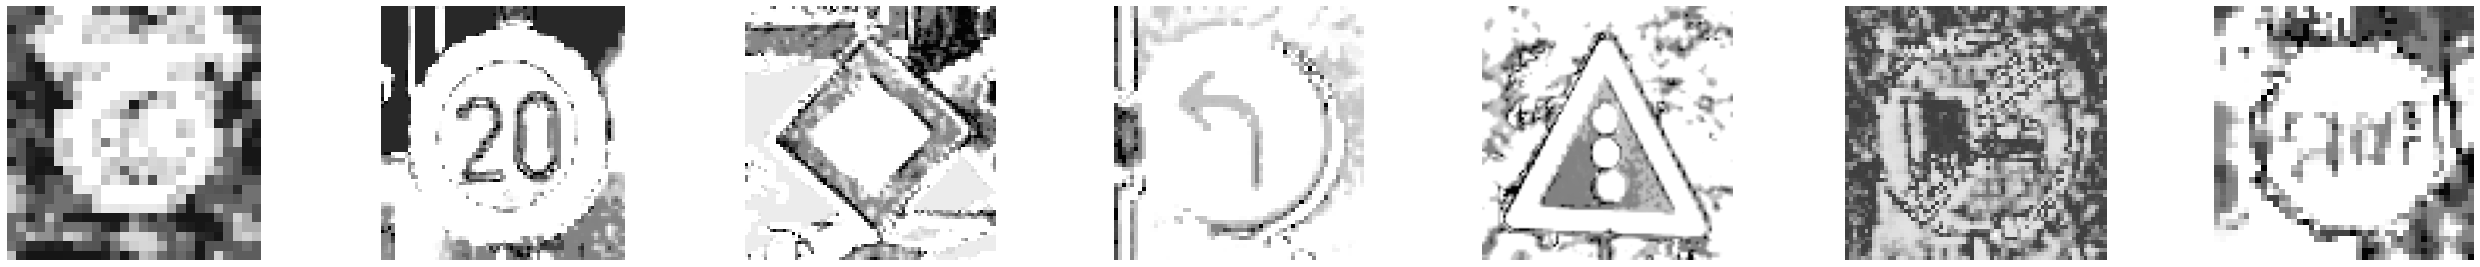

In [14]:
def conf(mah):
    conf = np.zeros(mah.shape)
    sorted_mah = np.sort(mah, axis = None)
    trimmed_mah = sorted_mah[int(len(sorted_mah)*0.05):-int(len(sorted_mah)*0.05)]
    #lambdas = [0, trimmed_mah[int(0.1*len(trimmed_mah))], trimmed_mah[int(0.5*len(trimmed_mah))]]
    #weights = [0.5, 0.35, 0.15]
    lambdas = [0,10,100,np.median(mah)*0.5]
    weights = [0.25,0.25,0.25,0.25]
    for l, w in zip(lambdas, weights): #fixed values
        conf += (posterior_H1_given_d(mah,l, l, np.median(trimmed_mah)*1.75)*w)
    return conf

confs= []
for i, mah in enumerate(mah_distances):
    confs.append(conf(mah))
plot_images(images)
plot_images(confs)